# Reducing science images


In [1]:
from pathlib import Path

from matplotlib import pyplot as plt
import numpy as np

from astropy import units as u
import ccdproc as ccdp

from convenience_functions import show_image

In [2]:
# Use custom style for larger fonts and figures
plt.style.use('guide.mplstyle')

## Overview

[*Click here to comment on this section on GitHub (opens in new tab).*](https://github.com/mwcraig/ccd-reduction-and-photometry-guide/pull/214/files#diff-66be44bc5dc4da4585a24c563b32d10fR41){:target="_blank"}

[ccdproc](https://ccdproc.readthedocs.io) provides a couple of ways to approach
calibration of the science images:

+ Perform each of the individual steps manually using `subtract_bias`,
`subtract_dark`, and `flat_correct`.
+ Use the [`ccd_process` function](https://ccdproc.readthedocs.io/en/latest/api/ccdproc.ccd_process.html#ccdproc.ccd_process) to perform all of the reduction steps.

This notebook will do each of these in separate sections below.

In [3]:
def find_nearest_dark_exposure(image, dark_exposure_times, tolerance=0.5):
    """
    Find the nearest exposure time of a dark frame to the exposure time of the image,
    raising an error if the difference in exposure time is more than tolerance.
    
    Parameters
    ----------
    
    image : astropy.nddata.CCDData
        Image for which a matching dark is needed.
    
    dark_exposure_times : list
        Exposure times for which there are darks.
    
    tolerance : float or ``None``, optional
        Maximum difference, in seconds, between the image and the closest dark. Set
        to ``None`` to skip the tolerance test.
    
    Returns
    -------
    
    float
        Closest dark exposure time to the image.
    """

    dark_exposures = np.array(list(dark_exposure_times))
    idx = np.argmin(np.abs(dark_exposures - image.header['exptime']))
    closest_dark_exposure = dark_exposures[idx]

    if (tolerance is not None and 
        np.abs(image.header['exptime'] - closest_dark_exposure) > tolerance):
        
        raise RuntimeError('Closest dark exposure time is {} for flat of exposure '
                           'time {}.'.format(closest_dark_exposure, a_flat.header['exptime']))
        
    
    return closest_dark_exposure

## Example 1

[*Click here to comment on this section on GitHub (opens in new tab).*](https://github.com/mwcraig/ccd-reduction-and-photometry-guide/pull/214/files#diff-66be44bc5dc4da4585a24c563b32d10fR102){:target="_blank"}

The data in this example is from chip 0 of the Large Format Camera at Palomar
Observatory. In earlier notebooks we determined that:

+ This CCD has a [useful overscan region](01.08-Overscan.ipynb#Case-1:-Cryogenically-cooled-Large-Format-Camera-(LFC)-at-Palomar).
+ There is [no need to scale dark frames](05-03-Calibrating-the-flats.html#Subtracting-bias-is-not-necessary-in-this-example) in this data, and so no need to subtract bias.

First, we create [ImageFileCollection](https://ccdproc.readthedocs.io/en/latest/ccdproc/image_management.html)s for the raw data and the calibrated
data, and define variables for the image type of the flat field and the science
images (there are, unfortunately, no standard names for these).

In [4]:
reduced_path = Path('example1-reduced')

science_imagetyp = 'object'
flat_imagetyp = 'flatfield'
exposure = 'exptime'

ifc_reduced = ccdp.ImageFileCollection(reduced_path)
ifc_raw = ccdp.ImageFileCollection('example-cryo-LFC')

Next, a quick look at the science images in this data set.

In [5]:
lights = ifc_raw.summary[ifc_raw.summary['imagetyp'] == science_imagetyp.upper()]
lights['date-obs', 'file', 'object', 'filter', exposure]

date-obs,file,object,filter,exptime
str10,str14,str7,str2,float64
2016-01-16,ccd.037.0.fits,vv124_1,g',300.062
2016-01-16,ccd.043.0.fits,vv124_1,i',300.014


Next, a look at the calibrated combined images available to us.

In [6]:
combo_calibs = ifc_reduced.summary[ifc_reduced.summary['combined'].filled(False).astype('bool')]
combo_calibs['date-obs', 'file', 'imagetyp', 'object', 'filter', exposure]

date-obs,file,imagetyp,object,filter,exptime
str10,str27,str9,str6,str2,float64
2016-01-15,combined_bias.fit,BIAS,bias,i',0.0
2016-03-13,combined_dark_ 7.000.fit,DARK,dark,r',7.0
2016-03-13,combined_dark_300.000.fit,DARK,dark,r',300.0
2016-03-13,combined_dark_70.000.fit,DARK,dark,r',70.0
2016-01-16,combined_flat_filter_g'.fit,FLATFIELD,flat_g,g',70.001
2016-01-16,combined_flat_filter_i'.fit,FLATFIELD,flat_i,i',7.0


Both of these images will use the 300 second dark exposure to remove dark
current and there is a flat field image for each of the two filters present in
the data.

Though we could hard code which dark to use, it is possible to set up a
dictionary for accessing the darks, with a separate one for accessing the science
images. The goal is to write code that is more conveniently reused.

In [7]:
combined_darks = {ccd.header[exposure]: ccd for ccd in ifc_reduced.ccds(imagetyp='dark', combined=True)}
combined_flats = {ccd.header['filter']: ccd for ccd in ifc_reduced.ccds(imagetyp=flat_imagetyp, combined=True)}

The calibration steps for each of these science images are:

+ Subtract the overscan from the science image.
+ Trim the overscan.
+ Subtract the dark current (which in this case also includes the bias).
+ Flat correct the image.

These are the minimum steps needed to calibrate. Gain correcting the data and
identifying cosmic rays are additional steps that might often be done at this
stage. Identification of cosmic rays will be discussed in [this notebook](08-03-Cosmic-ray-removal.html).

In [8]:
# These two lists are created so that we have copies of the raw and calibrated images
# to later in the notebook. They are not ordinarily required.
all_reds = []
light_ccds = []
for light, file_name in ifc_raw.ccds(imagetyp=science_imagetyp, return_fname=True, ccd_kwargs=dict(unit='adu')):
    light_ccds.append(light)
    
    reduced = ccdp.subtract_overscan(light, overscan=light[:, 2055:], median=True)
    
    reduced = ccdp.trim_image(reduced[:, :2048])

    closest_dark = find_nearest_dark_exposure(reduced, combined_darks.keys())
    reduced = ccdp.subtract_dark(reduced, combined_darks[closest_dark],
                                 exposure_time=exposure, exposure_unit=u.second
                                )
    good_flat = combined_flats[reduced.header['filter']]
    reduced = ccdp.flat_correct(reduced, good_flat)
    all_reds.append(reduced)
    reduced.write(reduced_path / file_name)

/Users/mattcraig/miniconda3/envs/ccdguide/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


### Before and after for Example 1

[*Click here to comment on this section on GitHub (opens in new tab).*](https://github.com/mwcraig/ccd-reduction-and-photometry-guide/pull/214/files#diff-66be44bc5dc4da4585a24c563b32d10fR240){:target="_blank"}

The cell below displays each science image before and after calibration.

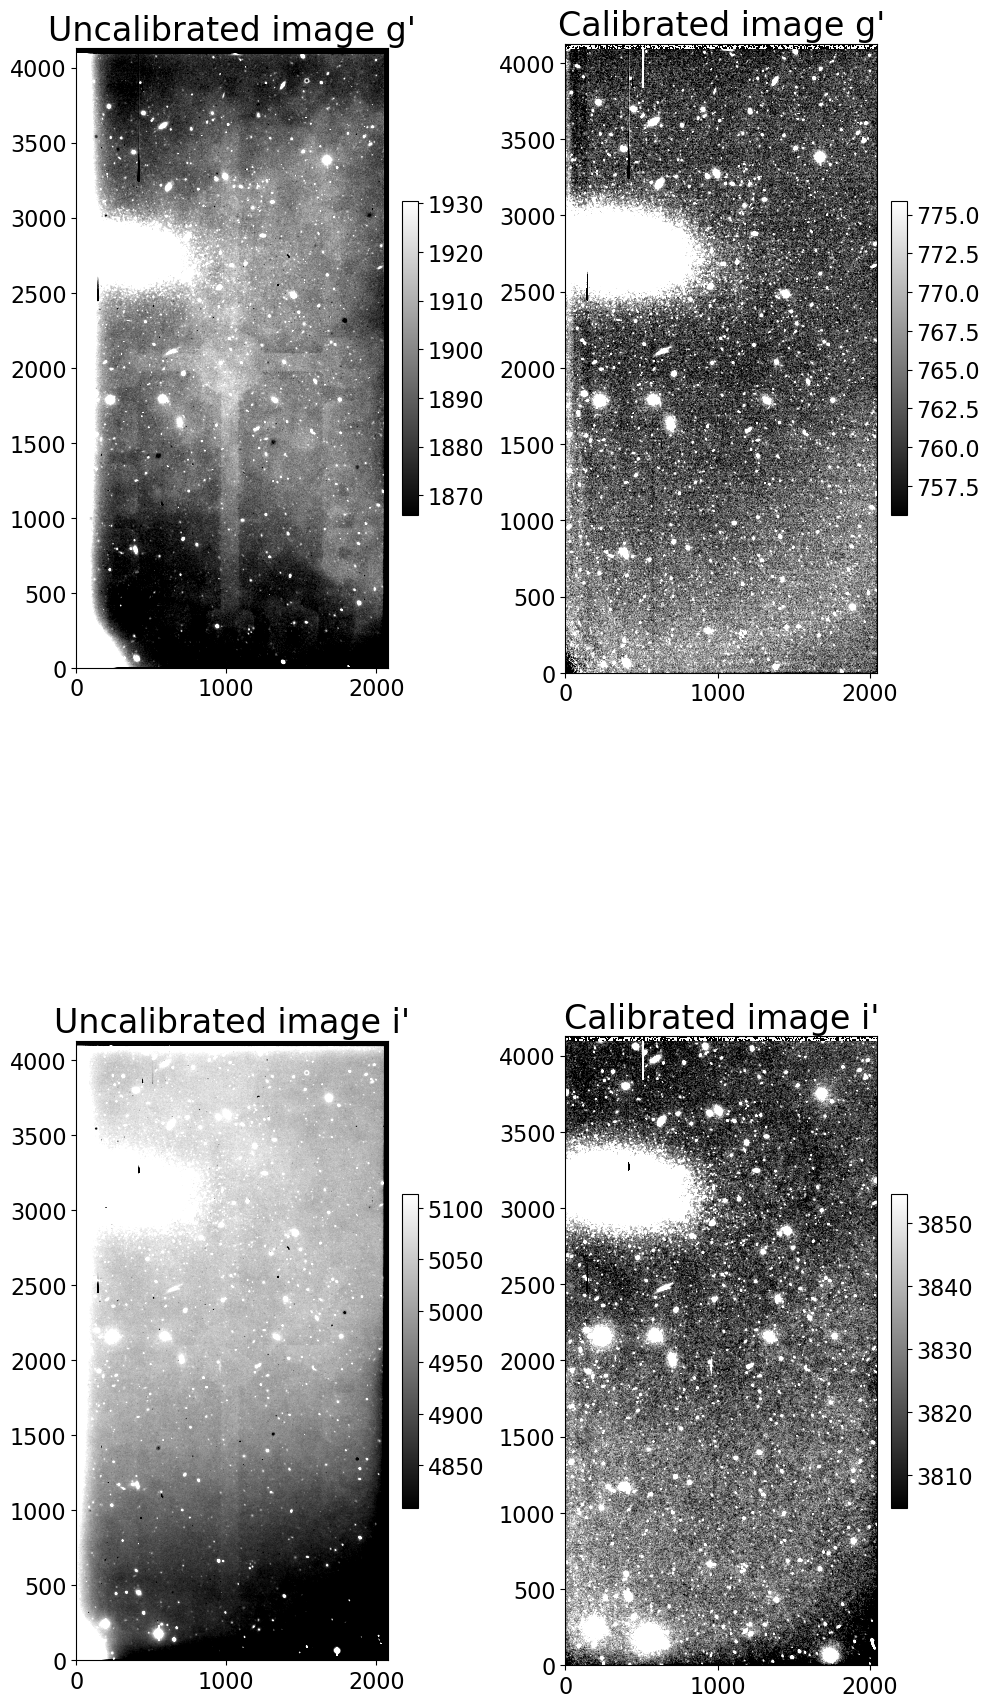

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(10, 20), tight_layout=True)

for row, raw_science_image in enumerate(light_ccds):
    filt = raw_science_image.header['filter']
    axes[row, 0].set_title('Uncalibrated image {}'.format(filt))
    show_image(raw_science_image, cmap='gray', ax=axes[row, 0], fig=fig, percl=90)

    axes[row, 1].set_title('Calibrated image {}'.format(filt))
    show_image(all_reds[row].data, cmap='gray', ax=axes[row, 1], fig=fig, percl=90)

In each reduced image the overall pattern in the flat field has been removed,
and the sensor glow along the left edge and in the bottom left corner of the
uncalibrated images has been removed. The background in the calibrated images is
still not perfectly uniform, though that background can be removed using
photutils if desired. The partial bad column visible in both uncalibrated images
is also still present in the calibrated images, particularly in the `g'` filter.

Those pixels will need to be masked, as described in the [notebook on bad
pixels](08-01-Identifying-hot-pixels.html).

## Example 2

The camera in this example is a thermoelectrically-cooled Andor Aspen CG16M. In
previous notebooks we decided that:

+ The overscan region of this camera is not useful.
+ For this data set the dark frames needed to be scaled, so we need to subtract
the bias frame from each science image.

First, we create [ImageFileCollection](https://ccdproc.readthedocs.io/en/latest/ccdproc/image_management.html)s for the raw data and the
calibrated data, and define variables for the image type of the flat field and
the science images (there are, unfortunately, no standard names for these).

In [10]:
reduced_path = Path('example2-reduced')

science_imagetyp = 'light'
flat_imagetyp = 'flat'
exposure = 'exposure'

ifc_reduced = ccdp.ImageFileCollection(reduced_path)
ifc_raw = ccdp.ImageFileCollection('example-thermo-electric')

Next, we check what science images are available.

In [11]:
lights = ifc_raw.summary[ifc_raw.summary['imagetyp'] == science_imagetyp.upper()]
lights['date-obs', 'file', 'object', 'filter', exposure]

date-obs,file,object,filter,exposure
str19,str31,object,object,float64
2018-08-23T09:00:21,kelt-16-b-S001-R001-C084-r.fit,kelt-16b,r,90.0
2018-08-23T10:29:30,kelt-16-b-S001-R001-C125-r.fit,kelt-16b,r,90.0


There are only two science images, both in the same filter and with the same
exposure time.

The combined calibration images available are listed below.

In [12]:
combo_calibs = ifc_reduced.summary[ifc_reduced.summary['combined'].filled(False).astype('bool')]
combo_calibs['date-obs', 'file', 'imagetyp', 'filter', exposure]

date-obs,file,imagetyp,filter,exposure
str19,str31,str4,object,float64
2018-08-23T11:20:07,combined_bias.fit,BIAS,--,0.0
2018-08-23T10:42:41,combined_dark_90.000.fit,DARK,--,90.0
2018-08-23T01:25:17,combined_flat_filter_r.fit,FLAT,r,1.0


Although there is only one of each type of combined calibration image, the code
below sets up a dictionary for the flats and darks. That code will work on a
more typical night when there might be several filters and multiple exposure
times.

In [13]:
combined_darks = {ccd.header[exposure]: ccd for ccd in ifc_reduced.ccds(imagetyp='dark', combined=True)}
combined_flats = {ccd.header['filter']: ccd for ccd in ifc_reduced.ccds(imagetyp=flat_imagetyp, combined=True)}

# There is only on bias, so no need to set up a dictionary.
combined_bias = [ccd for ccd in ifc_reduced.ccds(imagetyp='bias', combined=True)][0]

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


The calibration steps for each of these science images is:

+ Trim the overscan.
+ Subtract bias, because bias was subtracted from the dark frames.
+ Subtract dark, using the dark closest in exposure time to the science image.
+ Flat correct the images, using the combined flat whose filter matches the
science image.

In [14]:
all_reds = []
light_ccds = []
for light, file_name in ifc_raw.ccds(imagetyp=science_imagetyp, return_fname=True):
    light_ccds.append(light)

    reduced = ccdp.trim_image(light[:, :4096])
    
    # Note that the first argument in the remainder of the ccdproc calls is
    # the *reduced* image, so that the calibration steps are cumulative.
    reduced = ccdp.subtract_bias(reduced, combined_bias)
    
    closest_dark = find_nearest_dark_exposure(reduced, combined_darks.keys())

    reduced = ccdp.subtract_dark(reduced, combined_darks[closest_dark], 
                                 exposure_time='exptime', exposure_unit=u.second)
    
    good_flat = combined_flats[reduced.header['filter']]
    reduced = ccdp.flat_correct(reduced, good_flat)
    all_reds.append(reduced)
    reduced.write(reduced_path / file_name)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


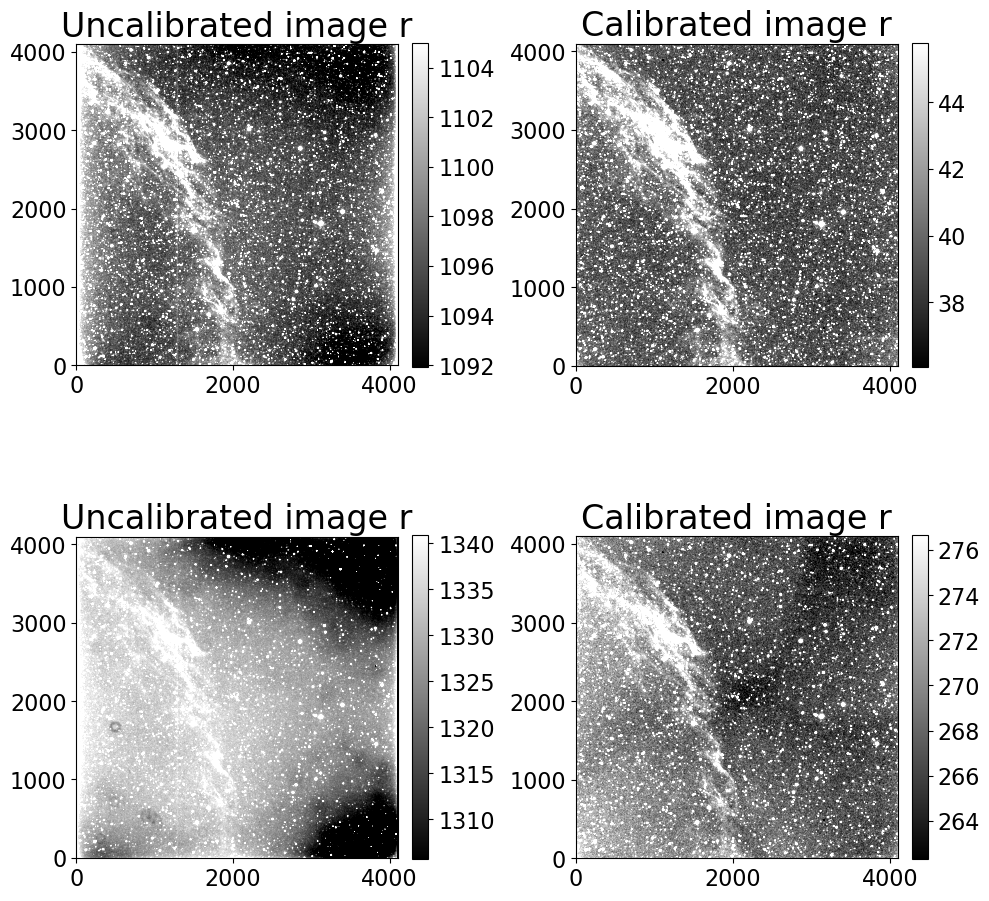

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10), tight_layout=True)

for row, raw_science_image in enumerate(light_ccds):
    filt = raw_science_image.header['filter']
    axes[row, 0].set_title('Uncalibrated image {}'.format(filt))
    show_image(raw_science_image, cmap='gray', ax=axes[row, 0], fig=fig, percl=90)

    axes[row, 1].set_title('Calibrated image {}'.format(filt))
    show_image(all_reds[row].data, cmap='gray', ax=axes[row, 1], fig=fig, percl=90)

In both images, most of the nonunifomity in the background has been removed along
the bright column and the sensor glow on the left and right edges of the
uncalibrated images.

The calibrated image in the top row looks like flat correction has led to a
fairly uniform background. The background in the image in the second row is not
that uniform. As it turns out the second image was taken much closer to dawn
than the first image, so the sky background really was not uniform when the
image was taken.